# Tiền xử lý dữ liệu
File này sẽ thực hiện các bước xử lý dữ liệu để chuẩn bị cho quá trình huấn luyện mô hình.

Mục tiêu chính:
1. Kiểm tra dữ liệu và xử lý thiếu giá trị (nếu có).
2. Chuẩn hóa và chuẩn hóa lại dữ liệu, đặc biệt là các cột 'Time' và 'Amount'.
3. Phân tích tương quan giữa các đặc trưng để xác định những đặc trưng quan trọng.
4. Lưu bộ dữ liệu đã xử lý vào thư mục 'data/processed/'.


### 1. Load dữ liệu

#### Thư viện cần thiết

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Đọc dữ liệu

In [21]:
# Đường dẫn dữ liệu
data_path = "../data/raw/creditcard.csv"

# Đọc dữ liệu
data = pd.read_csv(data_path)

# Thông tin cơ bản về dữ liệu
print("Thông tin dữ liệu:")
data.info()

# Xem 5 dòng đầu tiên
data.head()


Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  floa

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. Xử lý thiếu dữ liệu

In [22]:
# Kiểm tra giá trị thiếu
print("\nKiểm tra giá trị thiếu:")
missing_values = data.isnull().sum()
print(missing_values)

# Xác nhận không có giá trị thiếu
if missing_values.sum() == 0:
    print("Không có giá trị thiếu trong dữ liệu.")



Kiểm tra giá trị thiếu:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Không có giá trị thiếu trong dữ liệu.


Dữ liệu này không có giá trị thiếu nên không cần thực hiện bước điền giá trị.


### 3. Loại bỏ ngoại lệ (Outlier Detection & Removal)

#### Phát hiện ngoại lệ bằng IQR (Interquartile Range)

In [35]:
# Tính phân vị 99.5 của Amount trong lớp không gian lận (Class = 0)
threshold = data[data['Class'] == 0]['Amount'].quantile(0.9995)

print(f"Ngưỡng loại bỏ cho Amount (dựa trên phân vị 99.95): {threshold}")

# Loại bỏ các giao dịch có Amount vượt quá ngưỡng trong lớp không gian lận
data_cleaned = data[~((data['Class'] == 0) & (data['Amount'] > threshold))]

# Kết quả trước và sau khi loại bỏ
print(f"Số lượng giao dịch ban đầu: {len(data_cleaned)}")
print(f"Số lượng giao dịch sau khi loại bỏ ngoại lệ: {len(data_cleaned)}")


Ngưỡng loại bỏ cho Amount (dựa trên phân vị 99.95): 3820.7249799999945
Số lượng giao dịch ban đầu: 284664
Số lượng giao dịch sau khi loại bỏ ngoại lệ: 284664


#### So sánh trước và sau khi loại bỏ ngoại lệ (Visualization)

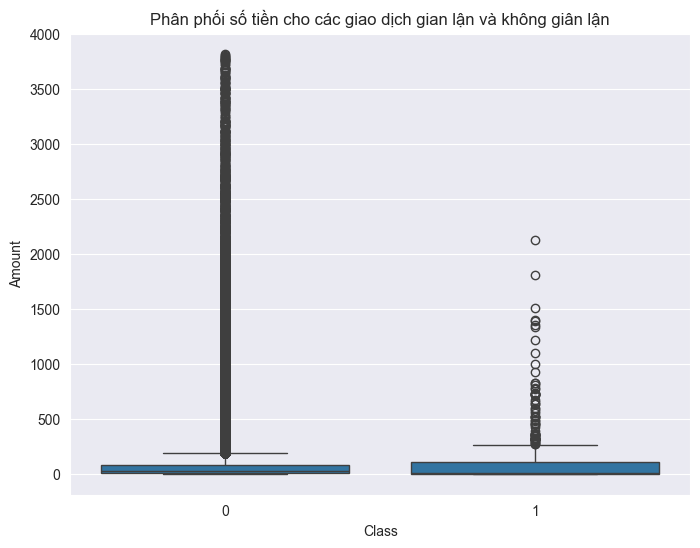

In [34]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Class', y='Amount',data = data_cleaned)
plt.title('Phân phối số tiền cho các giao dịch gian lận và không giân lận')
plt.show()

## 4. Chuẩn hóa dữ liệu (Normalization vs. Standardization)


Chuẩn hóa cột Amount và Time: Giúp các thuật toán học máy không bị ảnh hưởng bởi sự khác biệt về thang đo.

#### 3.1. Log Transformation

Giải thích: Chuyển đổi Amount để giảm ảnh hưởng của các giá trị cực lớn.

In [36]:
# Log transform cho cột Amount
data_cleaned['Log_Amount'] = np.log1p(data_cleaned['Amount'])

# So sánh trước và sau chuẩn hóa
print("Trước chuẩn hóa:", data_cleaned['Amount'].describe())
print("Sau chuẩn hóa:", data_cleaned['Log_Amount'].describe())


Trước chuẩn hóa: count    284664.000000
mean         85.580741
std         207.617633
min           0.000000
25%           5.560000
50%          22.000000
75%          77.000000
max        3820.000000
Name: Amount, dtype: float64
Sau chuẩn hóa: count    284664.000000
mean          3.149472
std           1.652609
min           0.000000
25%           1.880991
50%           3.135494
75%           4.356709
max           8.248267
Name: Log_Amount, dtype: float64


/var/folders/rz/mr63129s7vs6092h_t0czm140000gn/T/ipykernel_5270/2142103356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Log_Amount'] = np.log1p(data_cleaned['Amount'])


#### 3.2. Standardization

Giải thích: Chuẩn hóa dữ liệu bằng cách đưa về phân phối chuẩn (mean = 0, std = 1).

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardization cho Amount và Time
scaler = StandardScaler()
data_cleaned['Scaled_Amount'] = scaler.fit_transform(data_cleaned[['Amount']])
data_cleaned['Scaled_Time'] = scaler.fit_transform(data_cleaned[['Time']])


#### 3.3. Normalization (Min-Max)

Giải thích: Chuẩn hóa cột Amount trong khoảng [0, 1].

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
data_cleaned['Normalized_Amount'] = minmax_scaler.fit_transform(data_cleaned[['Amount']])
